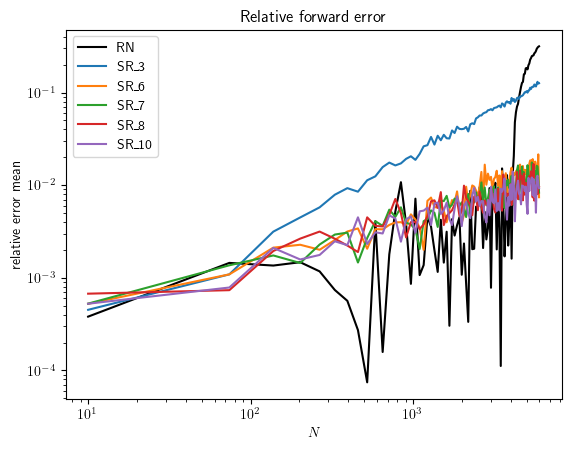

In [3]:
import srfloat as sr
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpmath import mp, mpf
import csv

matplotlib.rcParams['text.usetex'] = True

# set the random seeds for srfloat and numpy to get reproducible results
sr.seed(42)
np.random.seed(42)

# list of r values to test 
rand_bits = [3, 6, 7, 8, 10] 
r_len = len(rand_bits)

# RN and SR operators with parameterizable r value
cast_binary16_sr = lambda x, r : sr.cast_sr(x, 10, 5, r, True, False)
cast_binary16_rn = lambda x : sr.cast_rn(x, 10, 5, True, False)


# number of terms in the sums to test
Ns = [n for n in range(10, 6000, 64)]
errs_binary16_rn = []
errs_binary16_sr = [[] for _ in range(r_len)]
mp.prec = 300 # do multiple precision compute to compute reference result
runs = 10 # use a larger value for more representative averages (used 500 in the paper)


for N in Ns: 
    xs = [cast_binary16_rn(x) for x in (np.random.rand(N)).tolist()]
    sum_binary16_rn = 0.0
    sum_binary64_rn = 0.0
    sum_mp = mpf(0.0)
    for i in range(0, len(xs)):
        sum_binary64_rn += xs[i]
        sum_mp += mpf(xs[i])
        sum_binary16_rn = cast_binary16_rn(sum_binary16_rn + xs[i])

    err_binary64_rn = mp.fabs(mpf(sum_binary64_rn) - sum_mp) / mp.fabs(sum_mp)
    err_binary16_rn = mp.fabs(mpf(sum_binary16_rn) - sum_mp) / mp.fabs(sum_mp)

    err_binary16_sr_vec = [[] for _ in range(r_len)]
    for run in range(runs):
        sum_binary16_sr = [0.0 for _ in range(r_len)]
        err_binary16_sr = [0.0 for _ in range(r_len)]
        for i in range(0, len(xs)):
            for r in range(r_len):
                sum_binary16_sr[r] = cast_binary16_sr(sum_binary16_sr[r] + xs[i], rand_bits[r])

        for r in range(r_len):
            err_binary16_sr[r] = mp.fabs(mpf(sum_binary16_sr[r]) - sum_mp) / mp.fabs(sum_mp)
            err_binary16_sr_vec[r].append(err_binary16_sr[r])

    for r in range(r_len):
        err_binary16_sr[r] = np.mean(np.array(err_binary16_sr_vec[r]))


    errs_binary16_rn.append(err_binary16_rn)

    for r in range(r_len):
        errs_binary16_sr[r].append(err_binary16_sr[r])
        
# Save errs_binary16_rn
filename = 'errs_binary16_rn.csv'
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Error_rn'])  
    for err in errs_binary16_rn:
        writer.writerow([str(err)])  

# Save errs_binary16_sr
for r in range(len(rand_bits)):
    filename = f'errs_binary16_sr_{rand_bits[r]}.csv'
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        header = [f'Error_sr_{rand_bits[r]}']  # Header with rand_bits[r]
        writer.writerow(header)
        for err in errs_binary16_sr[r]:
            writer.writerow([str(err)])

plt.plot(Ns, errs_binary16_rn, color='k', label='RN')

for r in range(r_len):
    plt.plot(Ns, errs_binary16_sr[r], label=f'SR_{rand_bits[r]}')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$N$')
plt.ylabel('relative error mean')
plt.legend()
plt.title("Relative forward error")
plt.show()

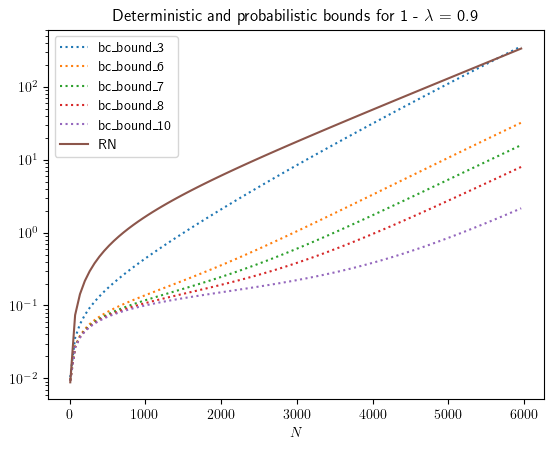

In [6]:
# variables for computing probabilistic bounds (binary16)
p=10
up = 2**(-p)
lam = 0.1
ahr = math.sqrt(math.log(2.0/lam))
bcr = math.sqrt(1.0/lam)
K = 1

bc_bound = [[] for _ in range(r_len)]
det_bound = []

for N in Ns:
    gamma_up = (1 + up)**(N-1) - 1 
    gamma_ah = (1 + up)**(2*(N-1)) - 1 
    gamma_bc = (1 + up**2)**(N-1) - 1
    for r in range(r_len):
        upr = 2**(-p -rand_bits[r])
        gamma_upr = (1+up+upr)**(N-1) -1
        bc_bound[r].append(K *(math.sqrt(gamma_bc) * bcr + gamma_upr - gamma_up))
    det_bound.append(K*(gamma_up))
for r in range(r_len):
    plt.plot(Ns, bc_bound[r], ':', label=f'bc_bound_{rand_bits[r]}')
plt.plot(Ns, det_bound, label='RN')

title = r"Deterministic and probabilistic bounds for 1 - $\lambda$ = " + str(1-lam)
plt.title(title)
plt.legend()
plt.yscale('log')
plt.xlabel(r'$N$')
plt.show()